In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# New data: VCR, GCE, PIE

Loading the new data.


In [2]:
#load images

XDIM = 2048
YDIM = 11*XDIM//8 # tried to get an arbitrary approximation that's also highly divisible by 2

#might want to do 1024 x 1024 instead, idk.

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        #print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img,(YDIM, XDIM))
            #warp so the mask is square
            #img = cv.warpPerspective(img,Mpad,(SIZE+2*PAD,SIZE+2*PAD))
            images.append(img)
    return images


In [3]:
gce_imgs = load_marsh_images("train_jpg/GCE")
pie_imgs = load_marsh_images("train_jpg/PIE")
vcr_imgs = load_marsh_images("train_jpg/VCR")
images = np.array([gce_imgs,pie_imgs,vcr_imgs])

In [5]:
#images = np.array([gce_imgs,pie_imgs,vcr_imgs])
images.shape

(3, 11, 2048, 2816)

In [6]:
#load masks
gce_mask = cv.imread("new-masks/updated_GCE_mask.jpg")
pie_mask = cv.imread("new-masks/updated_PIE_mask.jpg")
vcr_mask = cv.imread("new-masks/updated_VCR_map.jpg")

new_masks = [cv.cvtColor(gce_mask, cv.COLOR_BGR2GRAY), 
         cv.cvtColor(pie_mask, cv.COLOR_BGR2GRAY), 
         cv.cvtColor(vcr_mask, cv.COLOR_BGR2GRAY)]
masks = []
for m in new_masks:
    m = cv.resize(m,(YDIM,XDIM))
    masks.append(m)
new_masks = masks



In [32]:
#change the values in the mask to integers from 1 to 5 instead of the weird 0-255 values currently in there

THRESH = [90,125,140,180]


masks = []
weights = []
for mask in new_masks:
    int_mask = np.zeros_like(mask)
    for t in THRESH:
        is_bigger = mask >= t
        is_bigger = is_bigger.astype(int)
        int_mask = int_mask + is_bigger
        
    #the final one is the unlabeled stuff; so we get that and convert it to 0 on unlabeled and 1 on labeled
    #is_bigger = is_bigger.astype(bool)
    is_bigger = np.logical_not(is_bigger)
    is_bigger = is_bigger.astype(int)
    is_bigger = np.reshape(is_bigger, (1,XDIM,YDIM))
    
    int_mask = np.reshape(int_mask, (1,XDIM,YDIM))
    masks.append(int_mask)
    weights.append(is_bigger)
        
masks = np.array(masks)
weights = np.array(weights)

## Exploring new data

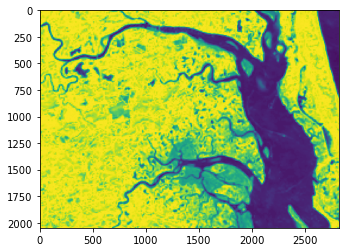

In [8]:
ax = plt.axes()

ax.imshow(pie_imgs[4])

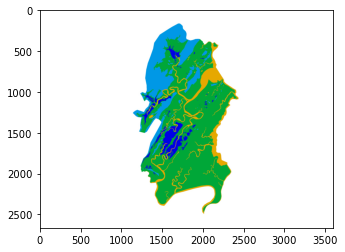

In [9]:
#look at new data
#plt.imshow(gce_mask)
#plt.imshow(pie_mask)
ax = plt.axes()


ax.imshow(vcr_mask)
#plt.imshow(grey_vcr_mask)
#it shows in the notebook!




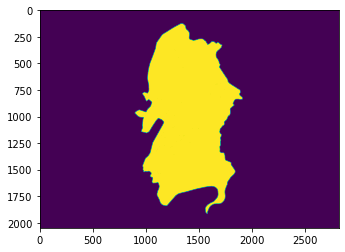

In [36]:
plt.imshow(weights[2][0])


## Test and train splits

I'm going to try a naive thing where I just convert the upper half of the mask to the unknown class.



In [10]:
te_masks = []
tr_masks = []



for m in masks:
    x = np.zeros_like(m)
    y = np.zeros_like(m)
    x.fill(4)
    y.fill(4)
    #x = x + m
    #y = y + m
    x[0,:XDIM//2,:]=m[0,:XDIM//2,:]
    #y[0,:YDIM//2,:]=4
    #x[0,YDIM//2:,:]=4
    y[0,XDIM//2:,:]=m[0,XDIM//2:,:]

    te_masks.append(x)
    tr_masks.append(y)

te_masks = np.array(te_masks)
tr_masks = np.array(tr_masks)
    


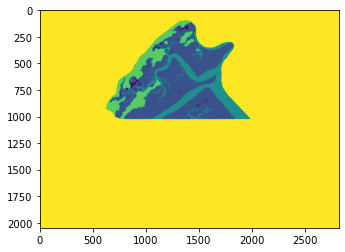

In [11]:
#see if it works
plt.imshow(te_masks[0,0])

# Converting to dataset

In [12]:
images.shape, masks.shape

((3, 11, 2048, 2816), (3, 1, 2048, 2816))

In [13]:
def get_tensor(images):
    images_tensor = tf.convert_to_tensor(images,dtype =tf.float32)
    
    SAMPLES,BANDS,HEIGHT,WIDTH = images_tensor.shape
    #print(list(a))
    #b = [1]
    #b.extend(list(a))
    #image_tensor = tf.reshape(images_tensor,[SAMPLES,HEIGHT,WIDTH,BANDS])
    image_tensor = tf.transpose(images_tensor,[0,2,3,1])
    return image_tensor

In [14]:
#get the data 

train_images = get_tensor(images)
train_masks = get_tensor(tr_masks)

test_images = get_tensor(images)

test_masks = get_tensor(te_masks)



train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))

test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_masks))



train_batches = (
    train_dataset
    .cache()
    #.shuffle(BUFFER_SIZE)
    .batch(3)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(3)

Metal device set to: Apple M1


2022-05-19 11:12:36.028926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-19 11:12:36.029399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# New shallower model
I'm going to try a much shallower model. I predict that it won't be able to differentiate ponds from ocean, but otherwise that it will outperform the deep model.

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

## Results from previous models
1. depth 1 encoders: ?
2. depth 2 fully conv encoder/decoder; 5000 epochs .857 val accuracy
3. depth 2 enc/dec concat with a dilated conv. 3000 epochs .856 val accuracy. 
    * the "same" padding for the dilated convolution creates massive artifacts at the beginning. I fear the minimization just downweights the dilated conv layer to avoid this. Because I actually have much more image to work with, there should be a way to avoid this. Make my input and output sizes different, THEN use "same" padding.
4. kernel size from 2 to 4: 3000 epochs .79 val accuracy (more overfit).
5. using more of the image to avoid edge effects: still around .85 val accuracy, but faster training - got there after only 2000 epochs.
6. More channels? Wider - go up to 10. Not much benefit, slightly more overfitting - going back down to 5. Ummm, this did terribly - accuracy went down to 65 on val, and pretty bad on train too. Fluke? 
7. Remove dilated channel concat. Slower train, slightly worse fit.
8. Put back dilated channel all filters 5, dilated channel filter size only 2. Pretty ok - 83 val accuracy. Very few parameters, best in terms of simplicity. Welll... actually wihtout the dilated conv does just fine. Also - only train 2k epochs. 3k doesn't seem to help.
10. Increase depth? Made val accuracy worse (75 percent). Looks very "pixelated." Definitely need the skips.
11. Deeper and without the dilation - got a bit better, amusingly. like 82.
12. Add skips. Got worse - like 72. What the heck? Even training didn't crack 50. Somehow qualitatively not that bad, though.
13. Augmentations - not yet; haven't even fit the actual data yet.
14. Decrease stride to 1: Real bad, basically reversed marsh and water and all kinds of bad stuff. Honestly it's unclear why it even happened.
15. Add a stride 1 deconv at the end to avoid checkerboards - best so far .85. Still some checkerboarding in the ponds.
16. Added a skip for the input - improvement at  .86.
17. Increase first filter size: minor improvement, still at .86
18. Replaced stride 2 by max-pool - bloody awful. undid.
19. Replaced second filter by 4x4 filter - also terrible. undid, went back up.
20. Replaced the first conv2dTranspose by a 4x4; try to integrate more information. Terrible. 
21. Replace conv2dTranspose by dilated.




## More ideas to try 

1. Augmentation 
2. Rebalance classes; ponds underrepresented. Perhaps what's happening is that it's a local min to "not care about ponds"
3. Pre-train by filling in missing spots in other satellite imagery. 
4. Regularize - it does seem like i've successfully overfit at this point? Wait - I should be showing the training loss/accuracy tending to zero.

In [ ]:
"""
#previous models 

#attempt no 1: just a single convolutional layer with filter 2x2 

#attempt no 2: encoder/decoder convolutional of depth 2, filters 2x2
#training for about 5000 epochs yielded val accuracy of .857

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    
    x = tf.keras.layers.Conv2D(10,2,2,activation="relu")(x)
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    
#attempt no 3: depth 2 enc/dec concat with a dilated conv.

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    
    #convolutional
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    
    
    #dilated convolution
    
    
    #usual convolution
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu")(x)
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=2,dilation_rate=10, padding="same",activation="relu")(x)
    
    #concat 
    concat = tf.keras.layers.Concatenate()
    x = concat([x,y])
    
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    
#attempt no 4: increase filter sizes

def shallow_model(output_channels:int):
    #inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #for debugging, fix input size
    inputs = tf.keras.layers.Input(shape=[256, 512, 11])
    
    #down
    
    #convolutional
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=3,strides=2,activation="relu")(inputs)
    
    
    #dilated convolution
    
    
    #usual convolution
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=3,strides=2,activation="relu")(x)
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=3,dilation_rate=10, padding="same",activation="relu")(x)
    
    concat = tf.keras.layers.Concatenate()
    x = concat([x,y])
    
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,3,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=4, strides=2,activation="relu")
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


"""

In [16]:
def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[XDIM, YDIM,11])
    
    #for debugging, fix input size
    #inputs = tf.keras.layers.Input(shape=[256, 512, 11])
    
    #down
    
    #first layer
    
    #convolutional
    x1 = tf.keras.layers.Conv2D(filters=5,kernel_size=4,strides=2,activation="relu",padding="same")(inputs)
    
    #second layer
    
    #usual convolution
    x2 = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu",padding="same")(x1)
    
    #maxpool
    #x2 = tf.keras.layers.MaxPooling2D(
    #pool_size=(2, 2), strides=None, padding="valid")(x2)
    
    
    """
    #dilated convolution
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=2,dilation_rate=8, padding="valid",activation="relu")(x)
    
    #crop x to be same size as y so concat makes sense 
    #if x has shape x1,x2 and y has shape y1,y2 we want 
    #the part of x that starts at ((x1-y1)/2, (x2-y2)/2) and ends at ((x_1 + y_1)/2, (x_2 + y_2)/2)
    #i.e. the "middle y" of x.
    xdim1,xdim2 = x.shape[1],x.shape[2]
    ydim1,ydim2 = y.shape[1],y.shape[2]
    crop1 = (xdim1-ydim1)//2
    crop2 = (xdim2-ydim2)//2
    x = tf.keras.layers.Cropping2D(cropping=((crop1, crop2), (crop1, crop2)))(x)
    #need to make x,y same size before concatenating - simply cut off some of x?
    x = concat([x,y])
    """
    
    #third layer 
    
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu",padding="same")(x2)
    #x = concat([x,x2])
    
    #up fourth layer
    
    x = tf.keras.layers.Conv2DTranspose(10,2,2,activation="relu",padding="same")(x)
    
    concat = tf.keras.layers.Concatenate()

    x = concat([x,x2])
    #fifth layer
    
    #dilation
    #x = tf.keras.layers.Conv2DTranspose(5,2,dilation_rate=2,activation="relu",padding="same")(x)
    #then upsample
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu",padding="same")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=5, kernel_size=2, strides=2,activation="relu")
    concat = tf.keras.layers.Concatenate()
    x = concat([x,x1])
    
    x=last(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=1, padding="same",activation="relu")
    
    concat = tf.keras.layers.Concatenate()
    x = concat([x,inputs])   
    x = last(x)
    
    #crop to correct output shape 
    
    #xdim1,xdim2 = x.shape[1],x.shape[2]
    #ydim1,ydim2 = y.shape[1],y.shape[2]
    #crop1 = (xdim1-ydim1)//2
    #crop2 = (xdim2-ydim2)//2
    #x = tf.keras.layers.Cropping2D(cropping=((PAD, PAD), (PAD, PAD)))(x)
    #need to make x,y same size before concatenating - simply cut off some of x?
    #x = concat([x,y])
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    


In [ ]:
# make a custom loss...hmm

def custom_loss(y_pred,y_true):
    

In [17]:
#OUTPUT_CLASSES = 4
OUTPUT_CLASSES=5


#if we do 4 classes, I guess we'll need to set the loss to CategoricalCrossentropy. 
#But does pix2pix even work with that? It seemed to not work earlier. 
model = shallow_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#better to figure out pad later on to get the right image size. 16 less than orig - so pad =8?

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 2816,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1408, 5 885         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 704, 10) 210         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 352, 10) 410         conv2d_1[0][0]                   
______________________________________________________________________________________________

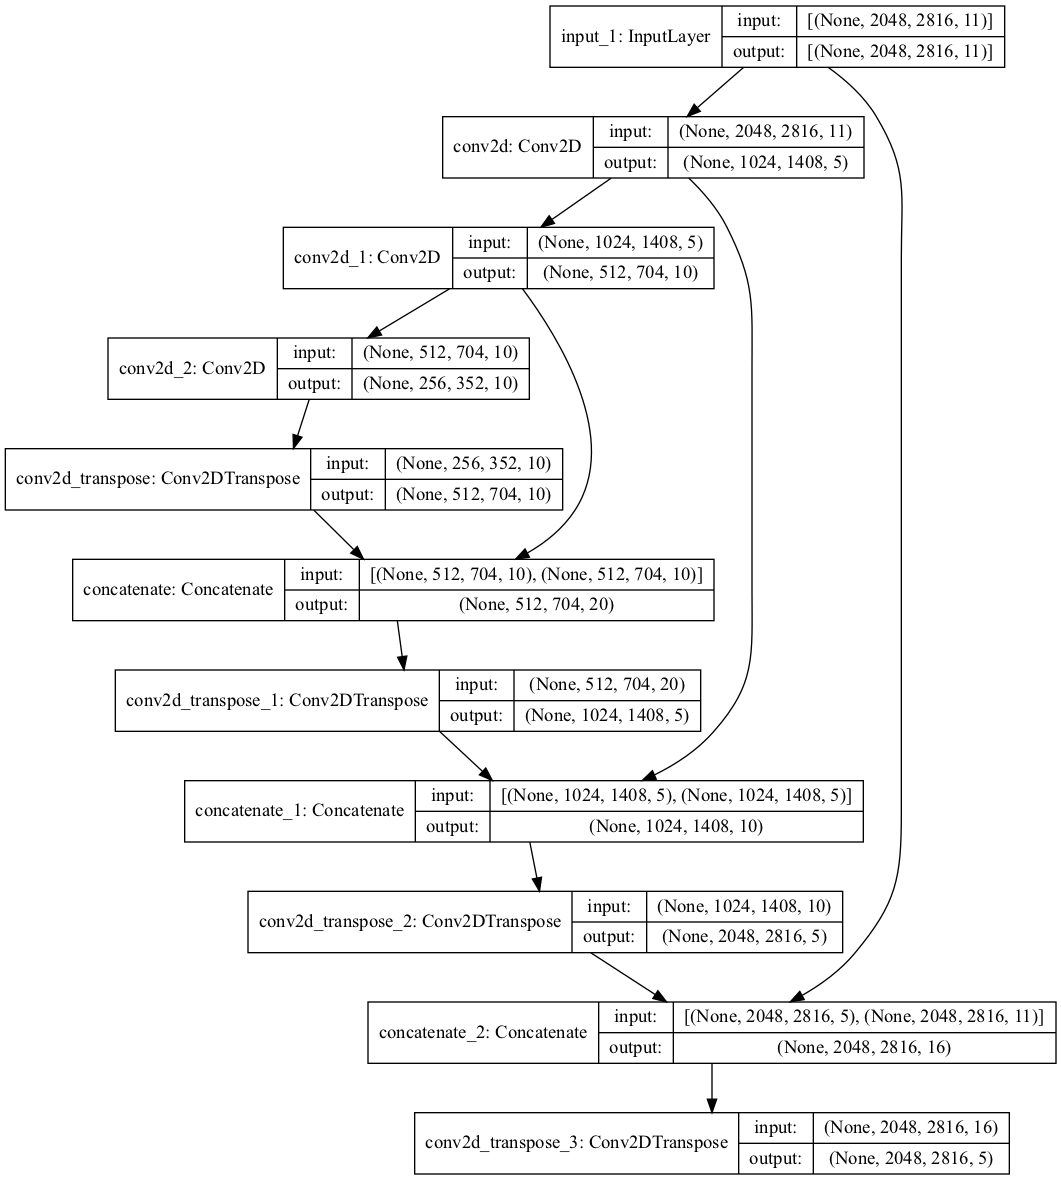

In [19]:
#256-208 = 48. try pad=24?
tf.keras.utils.plot_model(model, show_shapes=True)

# Testing the model

Try out the model to check what it predicts before training.

In [20]:
for image,mask in test_dataset.take(1):
    sample_image,sample_mask = image, mask
for image,mask in train_dataset.take(1):
    sample_train_image,sample_train_mask = image, mask
sample_image.shape,sample_mask.shape

(TensorShape([2048, 2816, 11]), TensorShape([2048, 2816, 1]))

In [21]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image, mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def show_train_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_train_image, sample_train_mask,
             create_mask(model.predict(sample_train_image[tf.newaxis, ...]))])
    
def show_predictions_loaded(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    if display_list[i].shape[-1]==1:
        mi = 0
        ma = 3
    else:
        mi = 4
        ma = 7
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,mi:ma]))
    plt.axis('off')
  plt.show()

2022-05-19 11:13:12.335087: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-19 11:13:12.407818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


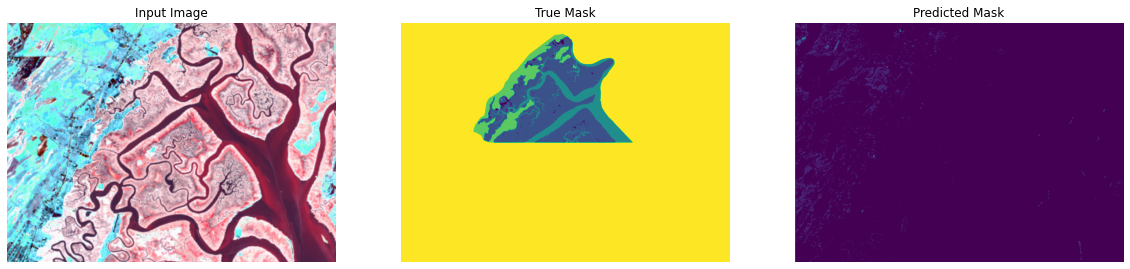

In [22]:
show_predictions()

# Training the model

In [37]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5==0:
        clear_output(wait=True)
        show_predictions()
    #show_train_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
tb_callback = tf.keras.callbacks.TensorBoard('./logs/SampleWeights10', update_freq=1)

2022-05-19 12:04:33.587228: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-05-19 12:04:33.587307: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-05-19 12:04:33.587887: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


In [24]:
## adding sample weights so that the final class is ignored 

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1,1,1,1, 0.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [25]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 2048, 2816, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2048, 2816, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2048, 2816, 1), dtype=tf.float32, name=None))

In [44]:
#actually training 

EPOCHS = 10
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

#get validation working!

model_history = model.fit(train_batches.map(add_sample_weights), 
                          #class_weight = {0:1,1:1,2:1,3:1,4:0},
                          epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches.map(add_sample_weights),
                          callbacks=[DisplayCallback(),tb_callback]
                         )

ValueError: `class_weight` not supported for 3+ dimensional targets.

In [28]:
%load_ext tensorboard

In [29]:
%tensorboard --logdir logs/

# Weighted accuracy

figure out how to add pixel-wise sample weights. Confused how that works. First attempt will be to just supply an array of the same size as the set of y's I am trying to predict. Obviously the loss function knows that these y's are the output, so hopefully it will figure it out.

In [32]:
acc = tf.keras.metrics.SparseCategoricalAccuracy(
    name="sparse_categorical_accuracy", dtype=None
)

*Somebody's suggestion on github [https://github.com/keras-team/keras/issues/3653]:*

To follow up on this, I got it to work using sample_weight. It is quite nice if you know what you have to do. Unfortunately, the documentation is not really clear on this, presumably because this feature was originally added for time series data.

1. You need to reshape your 2D image-sized output as a vector before the loss function when you specify your model.
2. Use sample_weight_mode="temporal" when you compile the model. This will allow you to pass in a weight matrix for training where each row represents the weight vector for a single sample.

I hope that helps.

# saving/loading

In [196]:
model.save('saved-model-unpatched')

2022-03-04 14:56:46.599334: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-unpatched/assets


In [ ]:
loaded_model = tf.keras.models.load_model('saved-model-unpatched')

In [ ]:
show_predictions_loaded()